# Exercise 5: VQE

Name: Samantha Lang <br>
Score: 3 <br>
Error: 2.35881 mHa <br>
Number of parameters: 16 <br>

General approach: start with a custom hardware efficient ansatz (HEA) using simple rotation and entanglement blocks. Achieve an acceptable ground state energy by adjusting the transformers, reductions, ansatz repetitions, and optimizer hyperparameters based on the results.


In [1]:
from qiskit_nature.problems.second_quantization.electronic import ElectronicStructureProblem
from qiskit_nature.circuit.library import HartreeFock
from qiskit_nature.mappers.second_quantization import ParityMapper
from qiskit_nature.converters.second_quantization.qubit_converter import QubitConverter
from qiskit_nature.drivers import PySCFDriver
from qiskit_nature.transformers import FreezeCoreTransformer
from qiskit_nature.algorithms.ground_state_solvers.minimum_eigensolver_factories import NumPyMinimumEigensolverFactory
from qiskit_nature.algorithms.ground_state_solvers import GroundStateEigensolver
from qiskit.algorithms.optimizers import SLSQP
from qiskit.circuit.library import TwoLocal
from IPython.display import display, clear_output
from qiskit.algorithms import VQE
from qiskit.circuit import Parameter, QuantumCircuit, QuantumRegister
from qiskit import Aer

import numpy as np 

backend = Aer.get_backend('statevector_simulator')

The first two cells define and preprocess LiH under the following assumptions:
* Core orbitals were frozen.
* Unoccupied orbitals were removed to simplify the quantum circuit. 

Specifically, the two spin orbitals that contribute to antibonding MO 3$\sigma^*$ were removed from the problem. These spin orbitals correspond to the row indices 3 and 4. Note that the orbital indices can be determined by the row number of a fully reduced row in qmolecule.one_body_integrals, but this step is omitted for brevity.

In [2]:
molecule = 'Li 0.0 0.0 0.0; H 0.0 0.0 1.5474'
driver = PySCFDriver(atom=molecule)
qmolecule = driver.run()

# Freeze core
freezer = FreezeCoreTransformer(freeze_core = True, remove_orbitals=[3,4])

In [3]:
# VQE data callback function (provided in ex. 5)
def callback(eval_count, parameters, mean, std):  
    display("Evaluation: {}, Energy: {}, Std: {}".format(eval_count, mean, std))
    clear_output(wait=True)
    counts.append(eval_count)
    values.append(mean)
    params.append(parameters)
    deviation.append(std)

The next two cells construct the ElectronicStructureProblem to then form the qubit operators, map the problem Hamiltonian to a minimum number of qubits, and sets the InitialState of the ansatz circuit as a Fock matrix.

ParityMapper() was arbitrarily chosen as the fermionic mapping method among those available in Qiskit Nature because it best reduced the number of qubits used in the ansatz.

In [4]:
# Create e- structure
problem = ElectronicStructureProblem(driver, q_molecule_transformers=[freezer])

# Generate the second-quantized operators
second_q_ops = problem.second_q_ops()

# Hamiltonian
main_op = second_q_ops[0]

# Mapper - Parity selected in order to use two_qubit_reduction
mapper = ParityMapper()

# Converter
converter = QubitConverter(mapper=mapper, two_qubit_reduction=True, z2symmetry_reduction = [1])

In [5]:
# Operator mapping
num_particles = (problem.molecule_data_transformed.num_alpha,
             problem.molecule_data_transformed.num_beta)
qubit_op = converter.convert(main_op, num_particles=num_particles)

# Generate LiH data for initial state
num_particles = (problem.molecule_data_transformed.num_alpha,
             problem.molecule_data_transformed.num_beta)
num_spin_orbitals = 2 * problem.molecule_data_transformed.num_molecular_orbitals

# Hartree-Fock initial state creates Fock matrix for N-body approximation
init_state = HartreeFock(num_spin_orbitals, num_particles, converter)

The eigenvalue for the ground state energy was solved by classical methods (diagonalization):

In [6]:
def exact_diagonalizer(problem, converter):
    solver = NumPyMinimumEigensolverFactory()
    calc = GroundStateEigensolver(converter, solver)
    result = calc.solve(problem)
    return result

result_exact = exact_diagonalizer(problem, converter)
exact_energy = np.real(result_exact.eigenenergies[0])
print("Exact electronic energy", exact_energy)

Exact electronic energy -1.0887060157347406


The HEA used here, based on [Kandala et al.](https://arxiv.org/pdf/1704.05018.pdf), is constructed by the add_ansatz method with the number of qubits used by qubit_op and init_state. For ease of implementation, the HEA was constructed out of TwoLocal by changing the entanglement method and block. Full access to qubit phases is provided by the rotation block sequence of RYRZ, whereas amplitude access is provided by the RY component and the CX entanglement block.

Only one repetition of TwoLocal was found necessary during the parameter reduction stage. The ansatz was initially run with 7 repetitions as recommended by the authors; however, VQE could not converge to an acceptable ground state energy with this large of an ansatz. Reducing the size to a less rigid QuantumCircuit, up to 3 repetitions, resulted in a ground state energy convergence within the required 4 mHa error bound. 

SLSQP was chosen as the optimizer among COBYLA and L_BFGS_B because it consistently reached more accurate ground state energies despite the other VQE parameters.

In [7]:
def add_ansatz(qubit_op, init_state, reps):
    # Implement single-layer hardware efficient ansatz using TwoLocal()
    ansatz = TwoLocal(qubit_op.num_qubits, rotation_blocks = ['ry', 'rz'], 
                      entanglement_blocks = ['cx'], reps = 1, entanglement = 'linear', 
                      skip_final_rotation_layer = False)
    ansatz.compose(init_state, front=True, inplace=True)
    return ansatz

In [8]:
# Set ansatz
ansatz = add_ansatz(qubit_op, init_state, reps = 1)

optimizer = SLSQP(maxiter = 10000)

counts = []
values = []
params = []
deviation = []

# Set initial parameters of the ansatz with predefined displacements for challenge
try:
    initial_point = [0.01] * len(ansatz.ordered_parameters)
except:
    initial_point = [0.01] * ansatz.num_parameters

algorithm = VQE(ansatz,
                optimizer=optimizer,
                quantum_instance=backend,
                callback=callback,
                initial_point=initial_point)

result = algorithm.compute_minimum_eigenvalue(qubit_op)

print(result)

{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 786,
    'eigenstate': array([ 1.39107837e-03+1.62872423e-04j, -4.80381191e-03-1.46983736e-04j,
        2.62455793e-02+8.47575473e-04j, -9.91330272e-01+1.36833755e-02j,
       -5.37457657e-02-3.77331021e-03j, -3.69359538e-04-8.90867623e-05j,
        8.79325469e-04-4.46380197e-06j, -2.32777011e-02+1.49212729e-03j,
       -2.67383906e-03-7.05383443e-05j, -1.12020626e-05-8.31917817e-06j,
        3.67368843e-06+2.34856862e-05j,  3.09706913e-04-9.10756570e-04j,
        1.13572137e-01-2.69517875e-03j,  5.55616499e-04+1.40861032e-04j,
       -5.49420576e-04+3.83215696e-05j, -2.93728468e-05-1.93995425e-05j]),
    'eigenvalue': -1.0863472033959158,
    'optimal_parameters': {   ParameterVectorElement(θ[1]): -0.005427469361328748,
                              ParameterVectorElement(θ[5]): 0.028613566643720716,
                              ParameterVectorElement(θ[2]): -3.1415190478209354,
                              ParameterVe

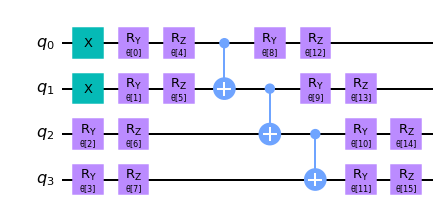

In [9]:
ansatz.draw(output='mpl')

In [10]:
print("Error: ", abs(exact_energy-result.optimal_value) * 1000, "mHa")

Error:  2.358812338824734 mHa
